# Lecture 13 - Resonance fluorescence

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, basis, correlation_2op_1t, mesolve, n_thermal, num,
                   sigmam, sigmap, sigmax, sigmay, sigmaz,
                   spectrum_correlation_fft)

%matplotlib inline

## Introduction

Resonance fluorescence, is the interaction between a two-level quantum system and a coherent driving field.

The Hamiltonian for a two-level system under resonant driving, is given by:

$\displaystyle H_L = -\frac{\Omega}{2}(\sigma_+ + \sigma_-)$


$\displaystyle \frac{d}{dt}\rho = -i[H_L, \rho] + \gamma_0(N+1)\left(\sigma_-\rho(t)\sigma_+ - \frac{1}{2}\sigma_+\sigma_-\rho(t) - \frac{1}{2}\rho(t)\sigma_+\sigma_-\right) + \gamma_0 N \left(\sigma_+\rho(t)\sigma_- - \frac{1}{2}\sigma_-\sigma_+\rho(t) - \frac{1}{2}\rho(t)\sigma_-\sigma_+\right)$


### Problem definition in QuTiP

In [2]:
# Rabi frequency (strength of the driving field)
Omega = 1.0 * 2 * np.pi

In [3]:
# decay rate of the two-level system
gamma0 = 0.05

# thermal frequency of the bath
w_th = 0.0

# thermal occupation number for the bath
N = n_thermal(Omega, w_th)

In [4]:
def system_spec(Omega, gamma0, N):
    HL = -0.5 * Omega * (sigmap() + sigmam())
    c_ops = [np.sqrt(gamma0 * (N + 1)) * sigmam(),
             np.sqrt(gamma0 * N) * sigmap()]
    return HL, c_ops

In [5]:
HL, c_ops = system_spec(Omega, gamma0, N)

In [6]:
e_ops = [sigmax(), sigmay(), sigmaz(), sigmam(), sigmap(), num(2)]

In [7]:
psi0 = basis(2, 0)

In [8]:
tlist = np.linspace(0, 20 / (2 * np.pi), 200)
result = mesolve(HL, psi0, tlist, c_ops, e_ops)

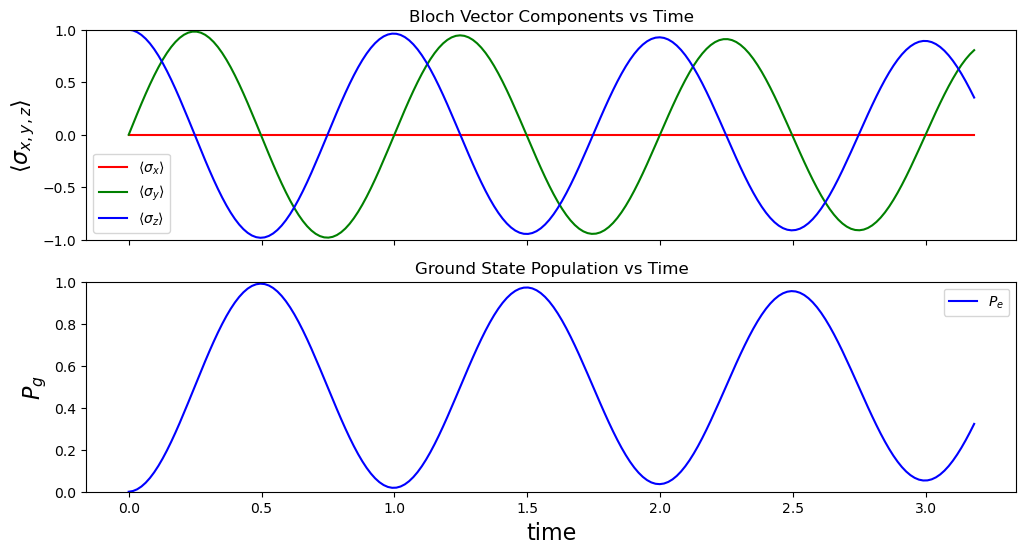

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(result.times, result.expect[0], "r",
             label=r"$\langle\sigma_x\rangle$")
axes[0].plot(result.times, result.expect[1], "g",
             label=r"$\langle\sigma_y\rangle$")
axes[0].plot(result.times, result.expect[2], "b",
             label=r"$\langle\sigma_z\rangle$")
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[0].set_ylabel(r"$\langle\sigma_{x,y,z}\rangle$", fontsize=16)
axes[0].set_title("Bloch Vector Components vs Time")

axes[1].plot(result.times, result.expect[5], "b", label=r"$P_e$")

axes[1].set_ylabel(r"$P_g$", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].set_title("Ground State Population vs Time");

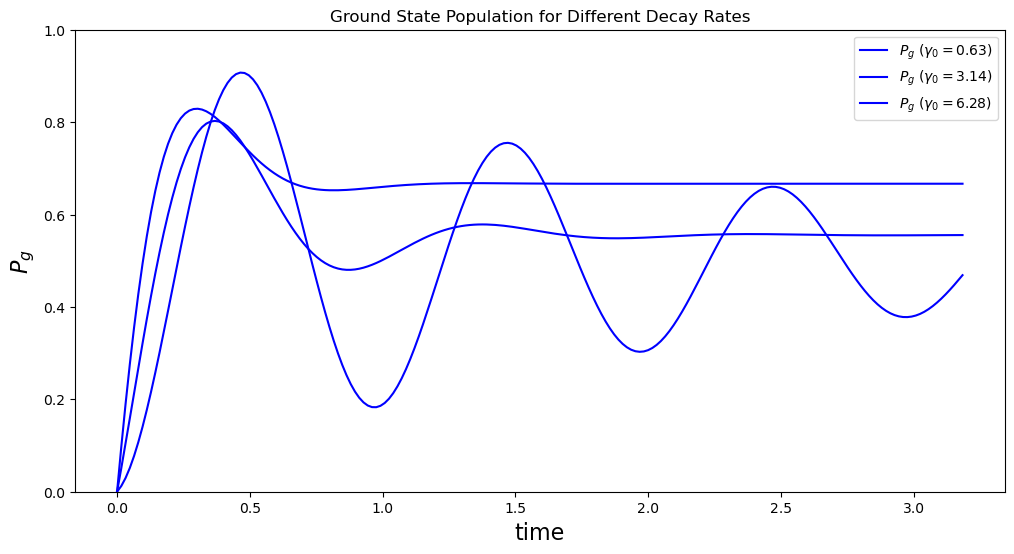

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

for idx, gamma0 in enumerate([0.1 * Omega, 0.5 * Omega, 1.0 * Omega]):

    HL, c_ops = system_spec(Omega, gamma0, N)
    result = mesolve(HL, psi0, tlist, c_ops, e_ops)

    ax.plot(
        result.times, result.expect[5], "b",
        label=fr"$P_g$ ($\gamma_0={gamma0:.2f}$)"
    )

ax.set_ylim(0, 1)
ax.set_xlabel("time", fontsize=16)
ax.set_ylabel(r"$P_g$", fontsize=16)
ax.set_title("Ground State Population for Different Decay Rates")
ax.legend();

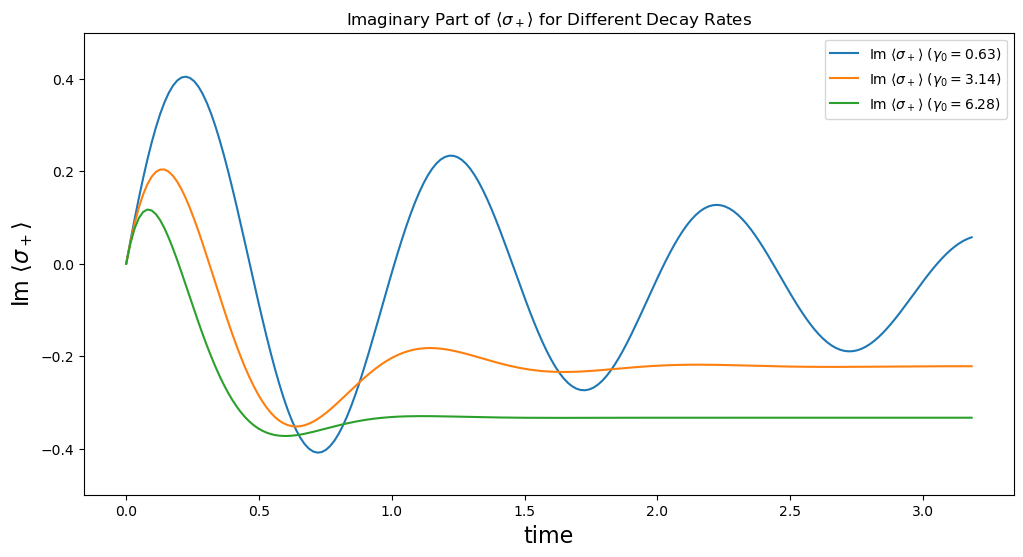

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

for idx, gamma0 in enumerate([0.1 * Omega, 0.5 * Omega, 1.0 * Omega]):

    HL, c_ops = system_spec(Omega, gamma0, N)
    result = mesolve(HL, psi0, tlist, c_ops, e_ops)

    ax.plot(
        result.times, np.imag(result.expect[4]),
        label=fr"Im $\langle\sigma_+\rangle$ ($\gamma_0={gamma0:.2f}$)"
    )

ax.set_ylim(-0.5, 0.5)
ax.set_xlabel("time", fontsize=16)
ax.set_ylabel(r"Im $\langle\sigma_+\rangle$", fontsize=16)
ax.set_title(r"Imaginary Part of $\langle\sigma_+\rangle$ for Different Decay Rates")
ax.legend();

/home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


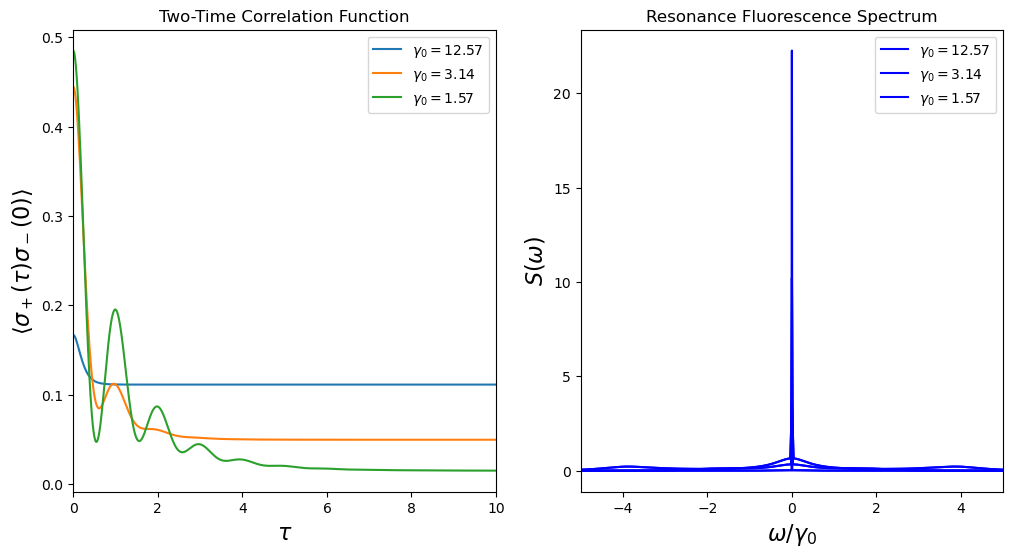

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

taulist = np.linspace(0, 100, 10000)

for idx, gamma0 in enumerate([2 * Omega, 0.5 * Omega, 0.25 * Omega]):

    HL, c_ops = system_spec(Omega, gamma0, N)
    corr_vec = correlation_2op_1t(HL, None, taulist, c_ops, sigmap(), sigmam())
    w, S = spectrum_correlation_fft(taulist, corr_vec)

    axes[0].plot(taulist, corr_vec, label=fr"$\gamma_0={gamma0:.2f}$")
    axes[1].plot(-w / (gamma0), S, "b", label=fr"$\gamma_0={gamma0:.2f}$")
    axes[1].plot(w / (gamma0), S, "b")

axes[0].set_xlim(0, 10)
axes[0].set_xlabel(r"$\tau$", fontsize=16)
axes[0].set_ylabel(r"$\langle\sigma_+(\tau)\sigma_-(0)\rangle$", fontsize=16)
axes[0].set_title("Two-Time Correlation Function")
axes[0].legend()

axes[1].set_xlim(-5, 5)
axes[1].set_xlabel(r"$\omega/\gamma_0$", fontsize=16)
axes[1].set_ylabel(r"$S(\omega)$", fontsize=16)
axes[1].set_title("Resonance Fluorescence Spectrum")
axes[1].legend();

### Software versions

In [13]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer